# Make theory predictions with a dimensionless emulator

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.likelihood import lya_theory
from lace.likelihood import likelihood
from lace.likelihood import likelihood_parameter

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=15
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

will drop sim number 15 from emulator


In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 1.7654E-09, n_s = 9.6590E-01, alpha_s = 0.0000E+00


### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# Set up emulator training set
z_max=4
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
## Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type="k_bin",passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 261 points
Optimised


### Define and compare Lya theories

We will setup two theories, one of them using the dimensionless emulator

In [6]:
verbose=False

In [7]:
old_theory=lya_theory.LyaTheory(data.z,emulator=emu,verbose=verbose,use_dimensionless=False)

In [8]:
new_theory=lya_theory.LyaTheory(data.z,emulator=emu,verbose=verbose,use_dimensionless=True)

working with dimensionless emulator


Define likelihood parameters

In [9]:
Delta2_star=0.36 # 0.36034
n_star=-2.3      # -2.2995
f_star=0.981      # 0.98139
g_star=0.968      # 0.96775
like_params=[]
like_params.append(likelihood_parameter.LikelihoodParameter(name='g_star',
                                        min_value=0.95,max_value=0.99,value=g_star))
like_params.append(likelihood_parameter.LikelihoodParameter(name='f_star',
                                        min_value=0.95,max_value=0.99,value=f_star))
like_params.append(likelihood_parameter.LikelihoodParameter(name='Delta2_star',
                                        min_value=0.25,max_value=0.4,value=Delta2_star))
like_params.append(likelihood_parameter.LikelihoodParameter(name='n_star',
                                        min_value=-2.35,max_value=-2.25,value=n_star))

Compare emulator calls

In [10]:
old_emu_calls=old_theory.get_emulator_calls(like_params=like_params)

In [11]:
new_emu_calls=new_theory.get_emulator_calls(like_params=like_params)

In [12]:
old_emu_calls[0]

{'Delta2_p': 0.6356860652265823,
 'n_p': -2.3031076238579113,
 'alpha_p': -0.21536149675796634,
 'mF': 0.8507256483811173,
 'gamma': 1.5534927645653829,
 'sigT_Mpc': 0.13085283960309124,
 'kF_Mpc': 9.233649502981942}

In [13]:
new_emu_calls[0]

{'Delta2_p': 0.6294269928186447,
 'n_p': -2.2999455848641577,
 'alpha_p': -0.21653062583389243,
 'mF': 0.8507256483811173,
 'gamma': 1.5534927645653829,
 'kT_kp': 11.074951258936695,
 'kF_kp': 13.381301633962273}

The emulator calls are slightly different, because we are not using (exactly) the same pivot point

In [14]:
linP_model=old_theory.cosmo.get_linP_model(like_params)
emu_kp_Mpc=emu.archive.kp_Mpc

In [15]:
for iz,z in enumerate(data.z):
    kp_kms_z=new_theory.cosmo.reconstruct_kp_kms_iz(iz,linP_model)
    dkms_dMpc_fid=new_theory.cosmo.Hz_fid[iz]/(1+z)
    old_kF_kms=old_emu_calls[iz]['kF_Mpc']/dkms_dMpc_fid
    new_kF_kms=new_emu_calls[iz]['kF_kp']*kp_kms_z
    old_kT_kms=(1/old_emu_calls[iz]['sigT_Mpc'])/dkms_dMpc_fid
    new_kT_kms=new_emu_calls[iz]['kT_kp']*kp_kms_z
    print(z,dkms_dMpc_fid,old_kF_kms/new_kF_kms,old_kT_kms/new_kT_kms)

2.0 67.85807679309228 0.9998924952253998 0.9998924952253996
2.25 70.07093072640048 0.9999224054638576 0.9999224054638576
2.5 72.2884578503019 0.9999500988169535 0.9999500988169537
2.75 74.49223564009783 0.9999758814012787 0.9999758814012788
3.0 76.67124499181399 1.0 1.0
3.25 78.81905326082351 1.000022656470859 1.0000226564708594
3.5 80.93210920645592 1.0000440180299135 1.0000440180299133
3.75 83.00868892172689 1.0000642247513127 1.0000642247513127
4.0 85.04823213711526 1.0000833951412549 1.0000833951412549


In [16]:
old_dp=np.array([call['Delta2_p'] for call in old_emu_calls])
new_dp=np.array([call['Delta2_p'] for call in new_emu_calls])
old_np=np.array([call['n_p'] for call in old_emu_calls])
new_np=np.array([call['n_p'] for call in new_emu_calls])

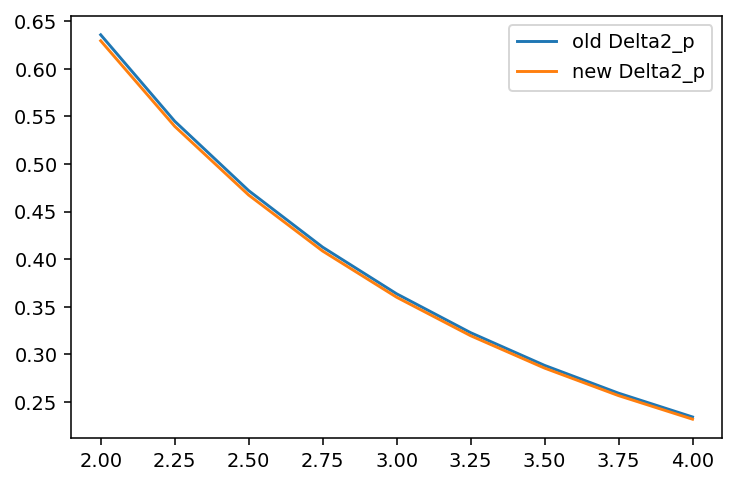

In [17]:
plt.plot(data.z,old_dp,label='old Delta2_p')
plt.plot(data.z,new_dp,label='new Delta2_p')
plt.legend()

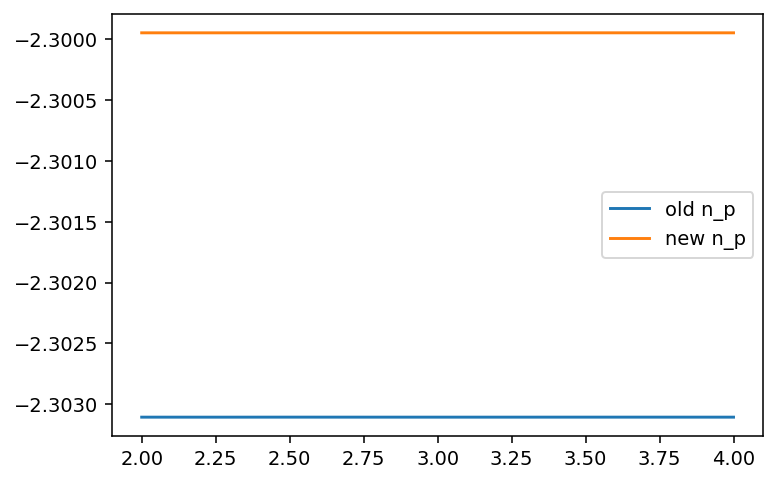

In [18]:
plt.plot(data.z,old_np,label='old n_p')
plt.plot(data.z,new_np,label='new n_p')
plt.legend()

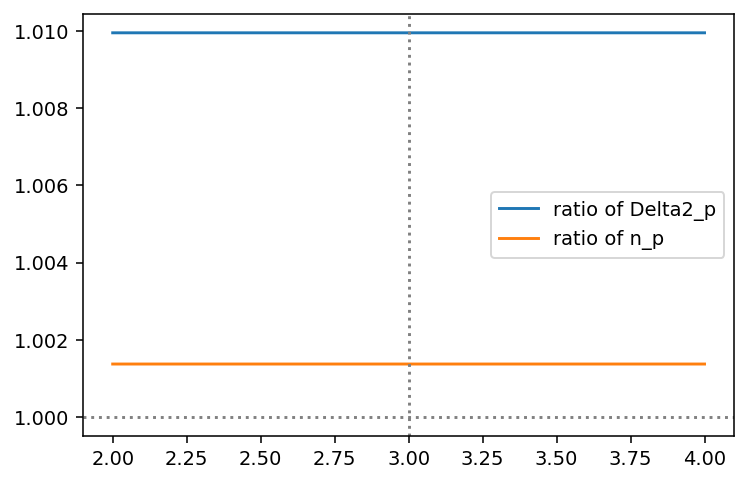

In [19]:
plt.plot(data.z,old_dp/new_dp,label='ratio of Delta2_p')
plt.plot(data.z,old_np/new_np,label='ratio of n_p')
plt.axhline(y=1,ls=':',color='gray')
plt.axvline(x=3,ls=':',color='gray')
plt.legend()

Compare P1D predictions

In [20]:
old_emu_p1d=old_theory.get_p1d_kms(k_kms=data.k,like_params=like_params)

In [21]:
new_emu_p1d=new_theory.get_p1d_kms(k_kms=data.k,like_params=like_params)

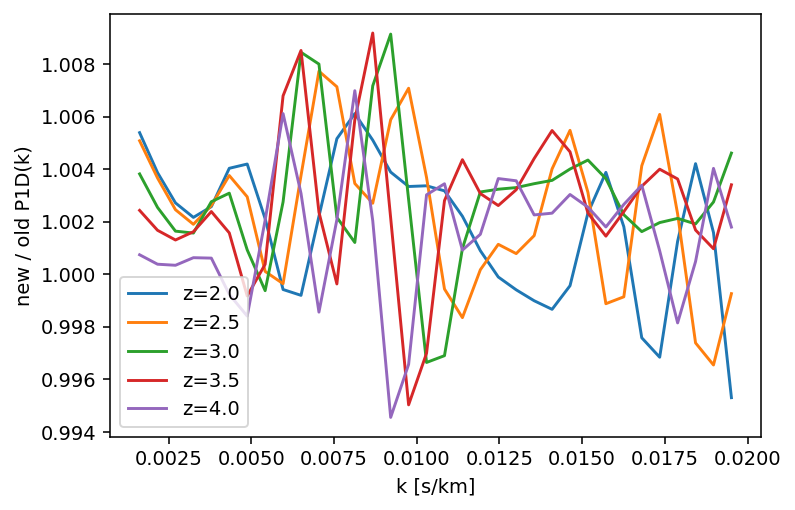

In [22]:
for iz in range(0,len(new_emu_p1d),2):
    plt.plot(data.k,new_emu_p1d[iz]/old_emu_p1d[iz],label='z={}'.format(data.z[iz]))
plt.xlabel('k [s/km]')
plt.ylabel('new / old P1D(k)')
plt.legend();

### Set up likelihoods

Here we chose which parameters we want to sample, over which range and chose a prior. We will setup a likelihood for each theory (one of them with the dimensionless emulator)

In [23]:
free_param_names=["Delta2_star","n_star","ln_tau_0"]
free_param_limits=[[0.24, 0.47], [-2.352, -2.25], [-0.2, 0.2]]
old_like=likelihood.Likelihood(data=data,theory=old_theory,
                            free_param_names=free_param_names,
                            free_param_limits=free_param_limits,
                            prior_Gauss_rms=None)

In [24]:
new_like=likelihood.Likelihood(data=data,theory=new_theory,
                            free_param_names=free_param_names,
                            free_param_limits=free_param_limits,
                            prior_Gauss_rms=None)

### Compare P1D predictions

In [25]:
old_emu_p1d=old_like.get_p1d_kms(k_kms=None,values=None,return_covar=False)

In [26]:
new_emu_p1d=new_like.get_p1d_kms(k_kms=None,values=None,return_covar=False)

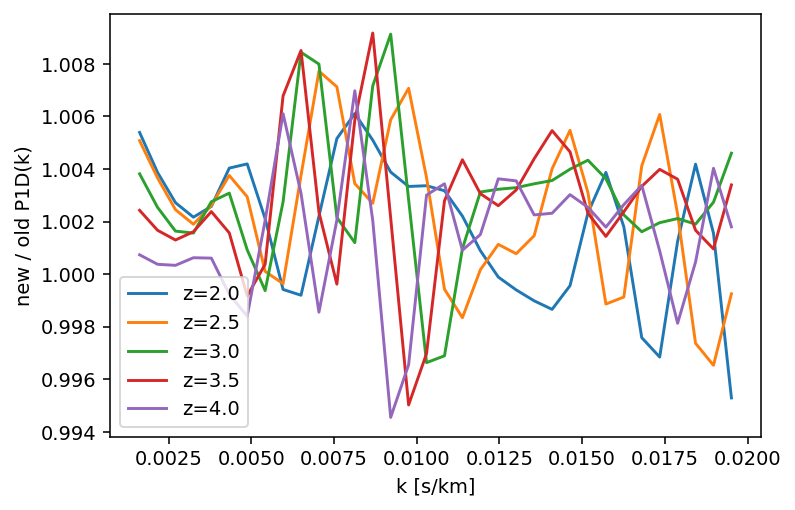

In [27]:
for iz in range(0,len(new_emu_p1d),2):
    plt.plot(data.k,new_emu_p1d[iz]/old_emu_p1d[iz],label='z={}'.format(data.z[iz]))
plt.xlabel('k [s/km]')
plt.ylabel('new / old P1D(k)')
plt.legend();

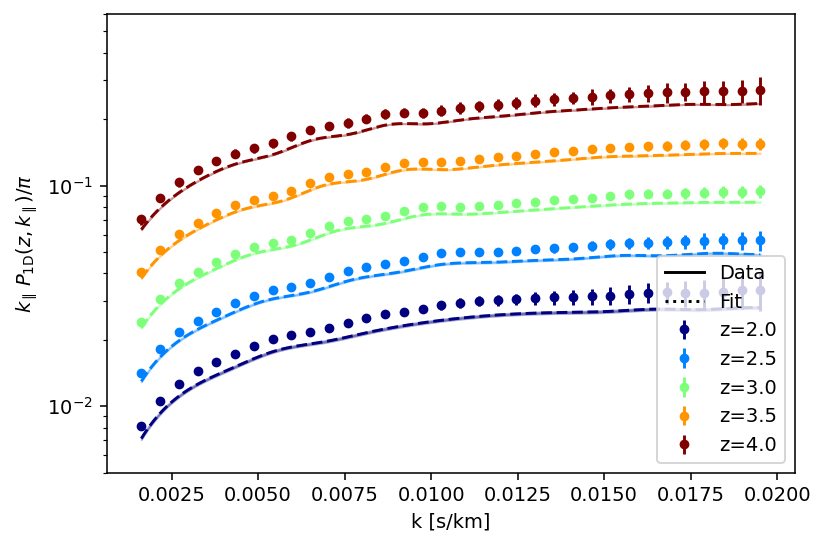

In [28]:
old_like.plot_p1d(plot_every_iz=2)

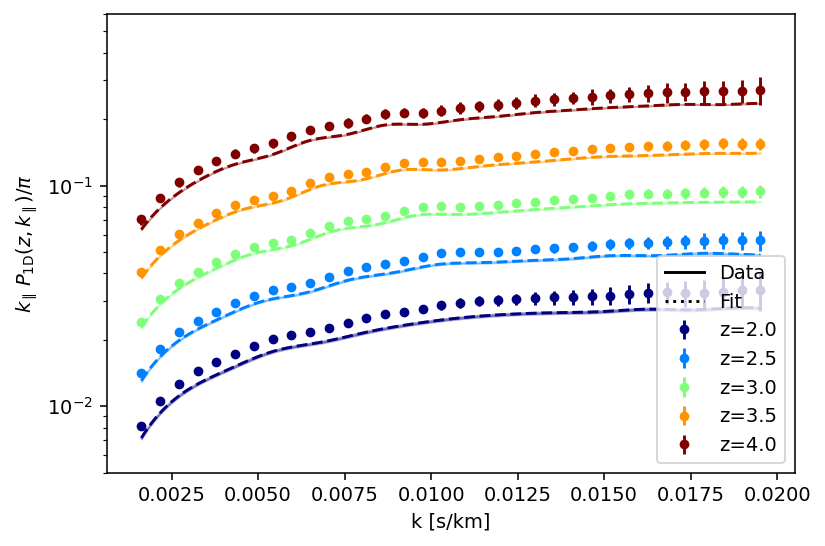

In [29]:
new_like.plot_p1d(plot_every_iz=2)